# Offset Ground-truthing

## In MintPy environment

In [1]:
# from mintpy.utils import readfile
%matplotlib inline
import os
import matplotlib.pyplot as plt
import seaborn as sns
from mintpy.tsview import timeseriesViewer
from mintpy.objects import timeseries
from datetime import datetime
import pandas as pd
import numpy as np
from scipy import interpolate

In [2]:
pwd

'/home/fw/data/pixeloffset_mintpy'

In [3]:
pegs = pd.read_csv('peg_data/pegs_32760.csv',index_col=0)
locations = pegs[['Name', 'Easting', 'Northing']].groupby('Name').mean().reset_index()
locations['row'] = None
locations['column'] = None

print(pegs.columns)

Index(['Survey date', 'Name', 'Survey number', 'Easting', 'Northing',
       'Elevation (NZVD2016)', 'E disp', 'N disp', 'V disp', 'Net H disp',
       'net H&V disp', 'net disp/yr', 'cum net disp', 'Cumulative E disp',
       'Cumulative N disp', 'geometry', 'Elevation'],
      dtype='object')


In [4]:
data_wd = 'poroa_32'
tsobj_ns = timeseries(os.path.join('..',data_wd,'timeseriesAz.h5'))
tsobj_ew = timeseries(os.path.join('..',data_wd,'timeseriesRg.h5'))

atr = tsobj_ns.get_metadata()
dates = tsobj_ns.get_date_list()
len(dates)

22

In [5]:
x_first, y_first, x_step, y_step = [float(x) for x in [atr['X_FIRST'], atr['Y_FIRST'], atr['X_STEP'], atr['Y_STEP']]]

for i, row in locations.iterrows():
    dX = row['Easting'] - x_first
    x_loc = int(np.floor(dX / x_step))
    dY = row['Northing'] - y_first
    y_loc = int(np.floor(dY / y_step))
    locations.iloc[i,3] = y_loc
    locations.iloc[i,4] = x_loc

In [6]:
cosicorr = pd.DataFrame()

template = pd.DataFrame({'Date':dates,'Cumulative E disp':None,'Cumulative N disp':None})
template['Date'] = pd.to_datetime(template['Date'], format='%Y%m%d')

for i, row in locations.iterrows():
    peg = template.copy()
    box = (row['column'],row['row'],row['column']+1,row['row']+1)
    peg['Cumulative N disp'] = tsobj_ns.read(box=box)
    peg['Cumulative E disp'] = tsobj_ew.read(box=box)
    peg['Name'] = row['Name']
    cosicorr = cosicorr.append(peg)

cosicorr = cosicorr.reset_index(drop=True)
cosicorr['Source'] = 'cosicorr'

reading timeseries data from file: ../poroa_32/timeseriesAz.h5 ...
reading timeseries data from file: ../poroa_32/timeseriesRg.h5 ...
reading timeseries data from file: ../poroa_32/timeseriesAz.h5 ...
reading timeseries data from file: ../poroa_32/timeseriesRg.h5 ...
reading timeseries data from file: ../poroa_32/timeseriesAz.h5 ...
reading timeseries data from file: ../poroa_32/timeseriesRg.h5 ...
reading timeseries data from file: ../poroa_32/timeseriesAz.h5 ...
reading timeseries data from file: ../poroa_32/timeseriesRg.h5 ...
reading timeseries data from file: ../poroa_32/timeseriesAz.h5 ...
reading timeseries data from file: ../poroa_32/timeseriesRg.h5 ...


In [7]:
pegs_merge = pegs[['Survey date', 'Cumulative E disp', 'Cumulative N disp', 'Name']].copy()
pegs_merge = pegs_merge.rename(columns={'Survey date':'Date'})
pegs_merge['Date'] = pegs_merge['Date'].astype('datetime64[ns]')
pegs_merge['Source'] = 'gps'
pegs_merge = pegs_merge.sort_values(['Name','Date']).reset_index(drop=True)

In [10]:
# df.groupby('filename').apply(lambda group: group.interpolate(method='index'))
pegs_interp = pd.DataFrame()
for p in pegs_merge.Name.unique():
    peg = pegs_merge.loc[pegs_merge['Name']==p].copy()
    peg['Time'] = (peg['Date'] - peg['Date'].min()).dt.days
    
    date_range = pd.date_range(start=peg.Date.min(), end=peg.Date.max(), freq='D')
    interp = pd.DataFrame({'Date':date_range,
                          'Name':p,
                          'Source':'gps'})
    interp['Time'] = (interp['Date'] - interp['Date'].min()).dt.days
    
    for d in ['N', 'E']:
        f = interpolate.interp1d(peg['Time'], peg[f'Cumulative {d} disp'])
        interp[f'Cumulative {d} disp'] = f(interp['Time'])

    pegs_interp = pegs_interp.append(interp).reset_index(drop=True)
    
pegs_interp = pegs_interp.sort_values(['Name','Date']).reset_index(drop=True).drop('Time',axis=1)

In [11]:
comparison = cosicorr.append(pegs_merge)
# comparison.to_csv('peg_data/comparsion.csv',index=False)

In [12]:
df_rmse = pd.DataFrame()
for p in pegs_merge.Name.unique():
    peg_tmp = pegs_merge.loc[pegs_merge['Name']==p].copy().sort_values('Date')
    cosicorr_tmp = cosicorr.loc[cosicorr['Name']==p].copy().sort_values('Date')
    
    start_date = peg_tmp.Date.min()
    end_date = peg_tmp.Date.max()
    
    peg_tmp = peg_tmp.loc[(peg_tmp.Date>=start_date) & (peg_tmp.Date<=end_date)].copy()
    peg_tmp['Time'] = (peg_tmp['Date'] - start_date).dt.days
    
    cosicorr_tmp = cosicorr_tmp.loc[(cosicorr_tmp.Date>=start_date) & (cosicorr_tmp.Date<=end_date)].copy()
    cosicorr_tmp['Time'] = (cosicorr_tmp['Date'] - start_date).dt.days
    
    rmses = {'Name':p,'N':0,'E':0}
    for d in ['N','E']:
        col = f'Cumulative {d} disp'
        col_gps = f'Cumulative {d} disp gps'
        f = interpolate.interp1d(peg_tmp['Time'], peg_tmp[col])
        
        cosicorr_tmp[col_gps] = f(cosicorr_tmp['Time'])
        cosicorr_tmp[col_gps] = cosicorr_tmp[col_gps] - cosicorr_tmp.iloc[0,-1]
        
        rmses[d] = ((cosicorr_tmp[col] - cosicorr_tmp[col_gps]) ** 2).mean() ** .5
    
    df_rmse = df_rmse.append(rmses,ignore_index=True)
    
    
print(df_rmse)

     Name          N          E
0  Peg 05   5.177986   1.915983
1  Peg 11   2.925732   0.449518
2  Peg 14   3.361200   0.539257
3  Peg 21  11.382754   5.449025
4  Peg 22   6.437214  30.623283


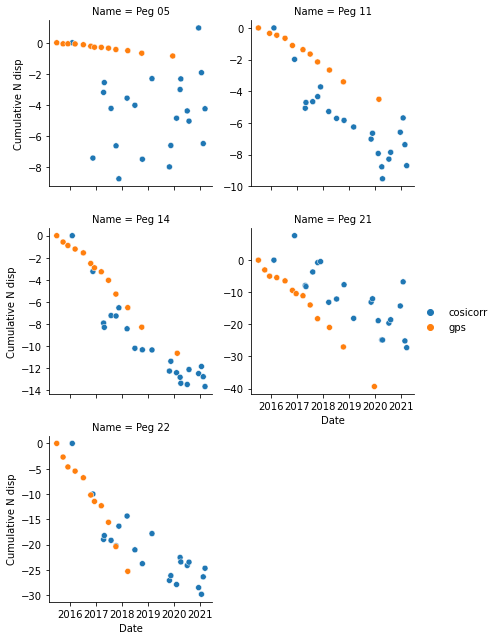

In [13]:
# comparison = pd.read_csv('peg_data/comparsion.csv',parse_dates=['Date'])
names = ['P5','P11','P14','P21','P22',]
g = sns.FacetGrid(comparison, col='Name',sharey=False, col_wrap=2)
g.map(sns.scatterplot, 'Date', 'Cumulative N disp','Source')
g.add_legend()

plt.savefig('n_displacement_comparison.png')

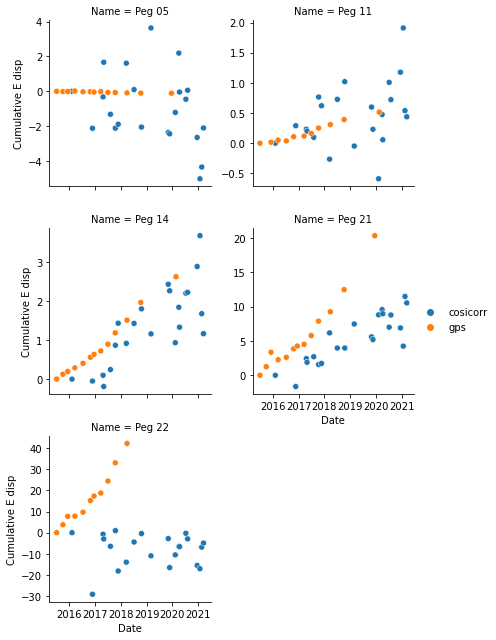

In [14]:
g = sns.FacetGrid(comparison, col='Name',sharey=False, col_wrap=2)
g.map(sns.scatterplot, 'Date', 'Cumulative E disp','Source')
g.add_legend()